# Question 1

Implementation of k-nearest neighbours and cross validation from scratch to better understand the algorithms. Each input x is classified according to the most frequent class amongst its k nearest neighbours as measured by the Euclidean distance (L2-norm).

In [0]:
import numpy as np
from scipy import stats

class NearestNeighbors:
  
  def __init__(self, n_neighbors=5):
    self.n_neighbors = n_neighbors
    self.X = []
    self.y = []

  def fit(self, X, y):
    self.X = X
    self.y = y

  def kneighbors(self, X):
    np_X = np.array(X)
    np_space = np.array(self.X)
    ret = []
    for i in range(np_X.shape[0]):
      dist = np.linalg.norm(np_space - np_X[i], axis=1)
      idx = np.argpartition(dist, self.n_neighbors)
      ret.append(list(idx[:self.n_neighbors]))
    return ret
  
  def predict(self, X):
    classifications = []
    set_neighbors = self.kneighbors(X)
    for i in range(len(set_neighbors)):
      neighbor_labels = []
      for index in set_neighbors[i]:
        neighbor_labels.append(self.y[index])
      # find most common classification of neighbor indeces
      classification = stats.mode(neighbor_labels)
      classifications.append(classification[0][0])
    return classifications
  
  def model_accuracy(self, X, y):
      classifications = self.predict(X)
      correct = 0
      for i in classifications:
        if classifications[i] == y[i]:
          correct += 1
      model_accuracy = correct / len(y)
      return model_accuracy

The dataset being used is a modified version of the Optical Recognition of Handwritten Digits Dataset from the UCI repository. It contains pre-processed black and white images of the digits 5 and 6. Each attribute indicates how many pixels are black in a patch of 4 x 4 pixels.

Format: there is one row per image and one column per attribute. The class labels are 5 and 6. The training set is already divided into 10 subsets for 10-fold cross validation.

In [0]:
import pandas as pd
import itertools

github_url = 'https://raw.githubusercontent.com/RohanK99/machine-learning/master/knn-dataset/'

# read test data
def read_test_data():  
  data_url = github_url + 'testData.csv'
  label_url = github_url + 'testLabels.csv'
  data = pd.read_csv(data_url, header=None)
  test_data = data.values.tolist()
  labels = pd.read_csv(label_url)
  test_labels = labels.values.tolist()
  return test_data, list(itertools.chain.from_iterable(test_labels))

# read training data
def read_training_data():
  training_data = []
  training_labels = []
  for i in range(10):
    url = github_url + 'trainData{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_data.append(data.values.tolist())
    url = github_url + 'trainLabels{}.csv'.format(i+1)
    data = pd.read_csv(url, header=None)
    training_labels.append(data.values.tolist())
  return training_data, training_labels

# X must be already be split into cv parts
def cross_validation(X, y, cv=10):
  accuracy = [0]*int((len(list(itertools.chain.from_iterable(X)))*((cv-1)/cv)))
  for i in range(0, len(X)):
    validation_set = X[i]
    validation_labels = list(itertools.chain.from_iterable(y[i]))
    training_set = list(itertools.chain.from_iterable(X[:i] + X[i+1:]))
    training_labels = list(itertools.chain.from_iterable( \
                        list(itertools.chain.from_iterable(y[:i] + y[i+1:]))))
    for k in range(1, len(training_set)): # try all K up till training_set size
      correct = 0 # number of correct classifications
      n = NearestNeighbors(n_neighbors=k) # k nearest neighbors 
      n.fit(training_set, training_labels) # train KNN with training set
      classifications = n.predict(validation_set) # predict validaton set
      for index in range(len(classifications)):
        # if validation set was predicted correctly increment counter
        if classifications[index] == validation_labels[index]:
          correct += 1
      # calculate average accuracy for all k-fold trials
      accuracy[k] = (accuracy[k] * i + (correct / len(validation_labels)))/(i+1)
  return range(len(training_set)), accuracy

The driver script runs 10 cross validation finding an optimal k. This parameter k is used for KNN prediction and finds the model accuracy relative to a test set. The k value might be skewed because for classification ties it is classified as the smaller of the 2 numbers. For a more optimal solution a weighted KNN should be used.

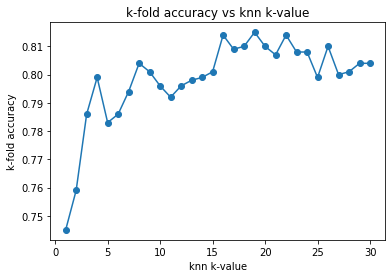

Optimal k: 19
Model Accuracy: 0.6697247706422018


In [20]:
import matplotlib.pyplot as plt

training_data, training_labels = read_training_data()
x, y = cross_validation(training_data, training_labels)
plt.plot(x[1:31], y[1:31], '-o') # peak can be found in first 30 values
plt.title('k-fold accuracy vs knn k-value')
plt.ylabel('k-fold accuracy')
plt.xlabel('knn k-value')
plt.show()

# format training_data for model_accuracy
training_data = list(itertools.chain.from_iterable(training_data))
training_labels = list(itertools.chain.from_iterable( \
                  list(itertools.chain.from_iterable(training_labels))))
test_data, test_labels = read_test_data()

k = y.index(max(y)) # optimal k
print("Optimal k: " + str(k))
n = NearestNeighbors(n_neighbors=k)
n.fit(training_data, training_labels)
print("Model Accuracy: " + str(n.model_accuracy(test_data, test_labels)))